In [122]:
#importing required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [123]:
#loading a data set
loan_details = pd.read_csv('loan.csv')
loan_details.shape
loan_details.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [124]:
#check for null rows
loan_details.isnull().all(axis=1).sum()

0

In [125]:
#check for empty columns in all rows
loan_details.isnull().all(axis=0).sum()

54

In [126]:
#drop 54 columns, which is null & not usefull for analysis
loan_details.dropna(axis=1,how='all',inplace=True)
loan_details.shape

(39717, 57)

In [127]:
#remove additional columns which seems like not usefull for analysis
loan_details.drop(['emp_title','url','desc','title','zip_code','initial_list_status','total_rec_late_fee','recoveries','collection_recovery_fee','policy_code','tax_liens'],axis=1,inplace=True)

In [128]:
loan_details.shape

(39717, 46)

In [129]:
#data formatting

In [130]:
#convert term to INT
loan_details['term'] = loan_details['term'].apply(lambda X: int(X[:-7]))

In [131]:
#convert int_rate to float
loan_details['int_rate'] = loan_details['int_rate'].apply(lambda X: float(X[:-1]))

In [132]:
#convert revolve_util to FLOAT
loan_details['revol_util'] = loan_details['revol_util'].str.rstrip('%').astype('float')

In [133]:
#convert emp_length to INT using regular expression
#there some rows having employ lenght as NULL, we can replace it with 0 for the analysis
loan_details['emp_length'].fillna('0',inplace=True)
loan_details['emp_length'] = loan_details['emp_length'].apply(lambda X: int(re.findall('\d+',X)[0]))

In [134]:
#checking weather any columns has most of the rows as 0
null_values_percentage  = (loan_details.isnull().sum() / len(loan_details)) * 100
null_values_percentage [null_values_percentage > 0]

mths_since_last_delinq        64.662487
mths_since_last_record        92.985372
revol_util                     0.125891
last_pymnt_d                   0.178765
next_pymnt_d                  97.129693
last_credit_pull_d             0.005036
collections_12_mths_ex_med     0.140998
chargeoff_within_12_mths       0.140998
pub_rec_bankruptcies           1.754916
dtype: float64

In [135]:
#most of the rows of column mths_since_last_delinq,mths_since_last_record,next_pymnt_d are having null values, we can drop this
loan_details.drop(['mths_since_last_delinq','mths_since_last_record','next_pymnt_d'],axis=1,inplace=True)

In [136]:
loan_details.shape

(39717, 43)

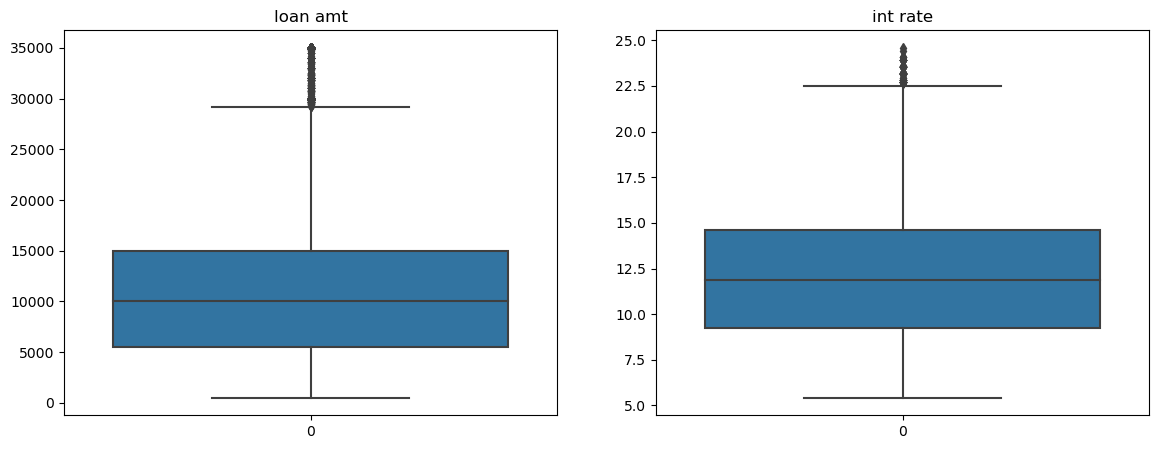

In [137]:
#removing outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(loan_details['loan_amnt'],ax=axes[0])
sns.boxplot(loan_details['int_rate'],ax=axes[1])
axes[0].set_title('loan amt')
axes[1].set_title('int rate')
plt.show()

#loan_amt & int_rate values are seems OK.

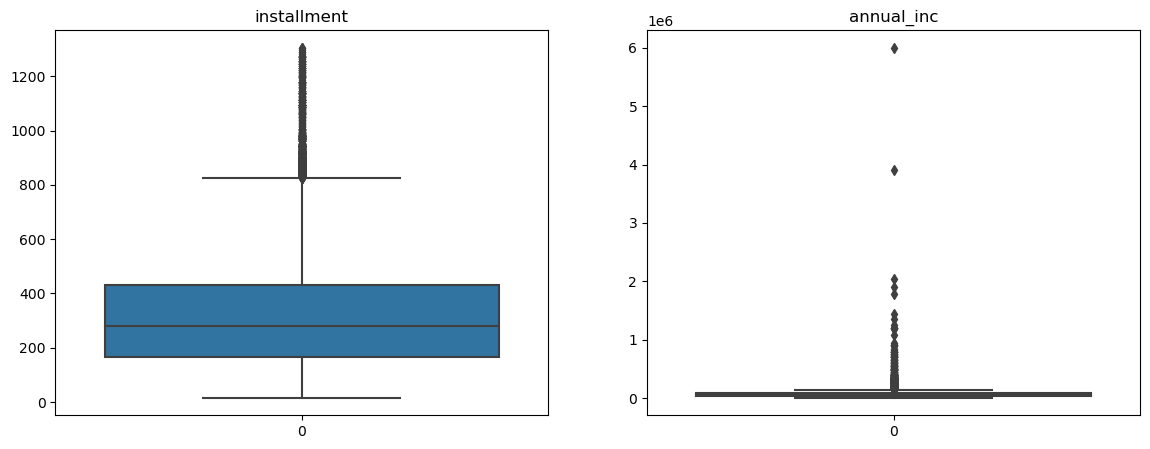

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(loan_details['installment'],ax=axes[0])
sns.boxplot(loan_details['annual_inc'],ax=axes[1])
axes[0].set_title('installment')
axes[1].set_title('annual_inc')
plt.show()

In [139]:
#the annual_inc has values exceeding outliers, delete rows exceeding 95% of quantile of annual_inc
loan_details.head()
loan_details = loan_details[(loan_details['annual_inc'] < loan_details['annual_inc'].quantile(0.95))]

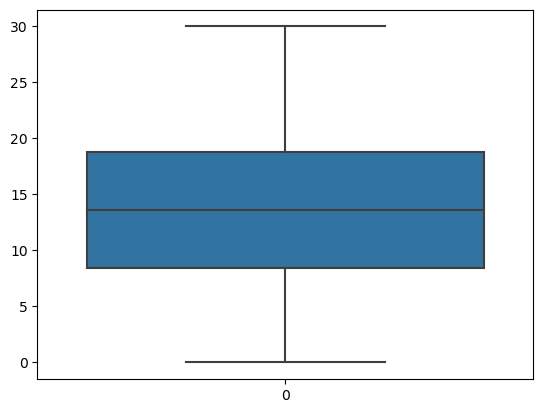

In [140]:
#check aoutlier in dti column
sns.boxplot(loan_details['dti'])
plt.show()
#the dti column looks OK

In [141]:
loan_details['loan_status'].value_counts()

Fully Paid     31256
Charged Off     5420
Current         1054
Name: loan_status, dtype: int64

In [142]:
#Since we are interested in risk in loan to be charge off, the current loan status may no be helpfull. We can delete the Current
#loan status records
loan_details = loan_details[(loan_details['loan_status'] != 'Current')]

default_statuses = ['Charged Off']
# Create a new column where 1 represents a default and 0 represents non-default.
loan_details['defaulted'] = loan_details['loan_status'].isin(default_statuses).astype(int)

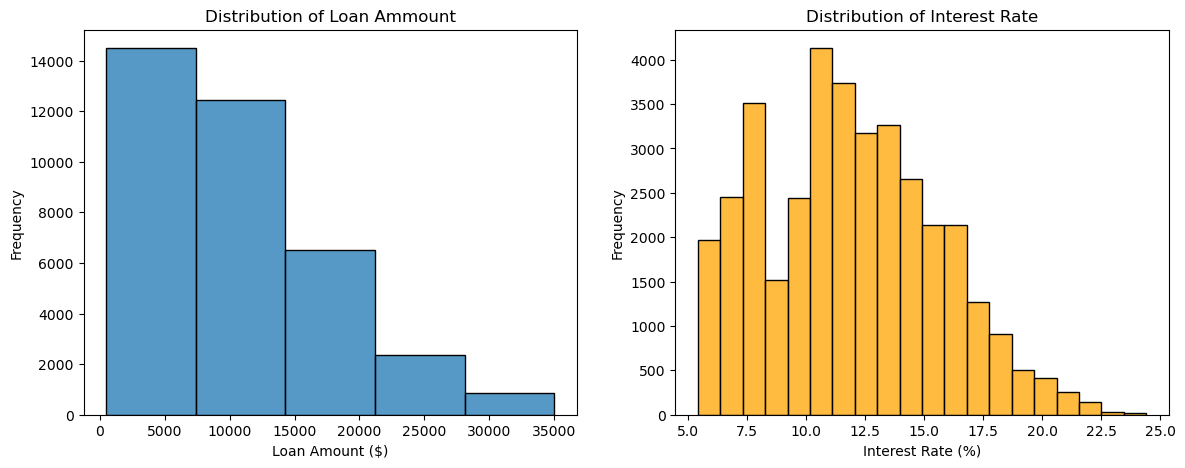

In [143]:
#univariate analysis on loan_amnt & int_rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(loan_details['loan_amnt'],ax=axes[0],bins=5)
sns.histplot(loan_details['int_rate'],ax=axes[1],bins=20, color='orange')
axes[0].set_title('Distribution of Loan Ammount')
axes[0].set_xlabel('Loan Amount ($)')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Distribution of Interest Rate')
axes[1].set_xlabel('Interest Rate (%)')
axes[1].set_ylabel('Frequency')

plt.show()

#1. most of the loan ammounts are sactioned at lower end of ammount requested i.e around 5000 to 10000
#2. Interest rate is varying howerver most of the loan applications had a interest rate ranging from 7.5 to 15.0.

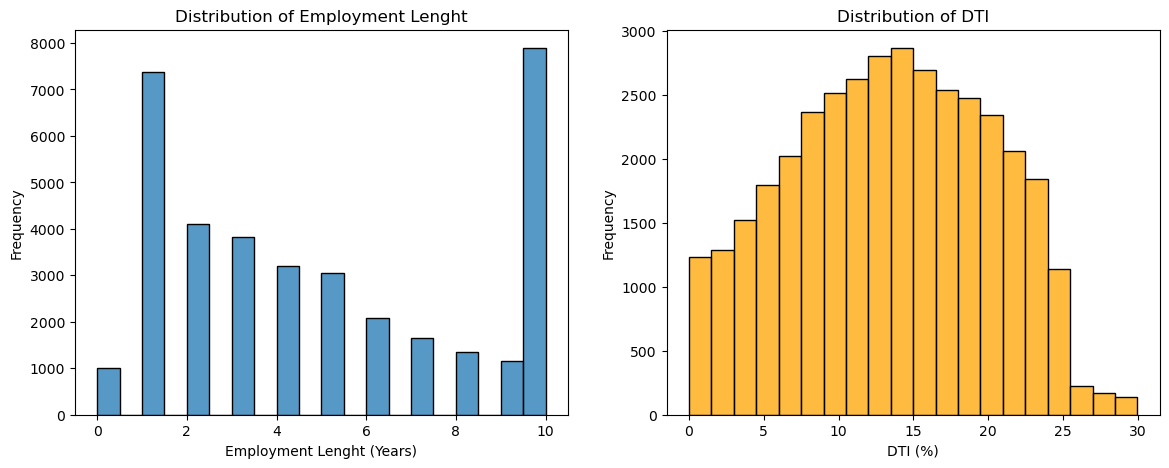

In [144]:
#univariate analysis on emp_length & dti
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(loan_details['emp_length'],ax=axes[0],bins=20)
sns.histplot(loan_details['dti'],ax=axes[1],bins=20, color='orange')
axes[0].set_title('Distribution of Employment Lenght')
axes[0].set_xlabel('Employment Lenght (Years)')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Distribution of DTI')
axes[1].set_xlabel('DTI (%)')
axes[1].set_ylabel('Frequency')
plt.show()

#1. most of the loan applicant have a employment experience of freshers (0 to 2 Years) or stable income with 10+ years.
#2. dti distribution is below 30%, howerver most loan applicant are having high dti risk ranging from 13 to 20%

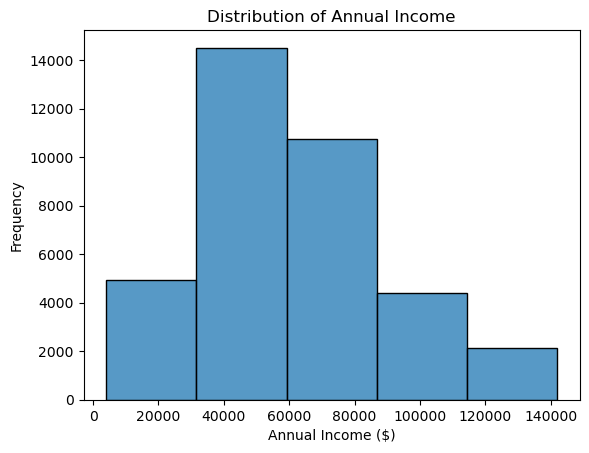

In [145]:
#univariate analysis on annual_inc
ax = sns.histplot(loan_details['annual_inc'],bins=5)
ax.set_title('Distribution of Annual Income')
ax.set_xlabel('Annual Income ($)')
ax.set_ylabel('Frequency')
plt.show()

#most of the loan applicant are having a stable income ranging from 40000 to 80000

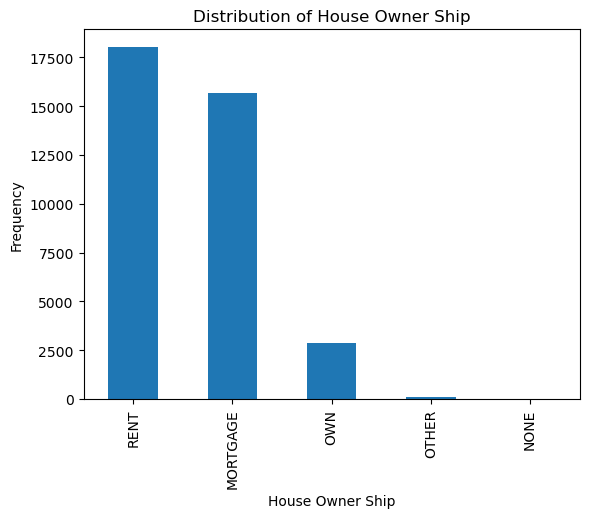

In [146]:
#univariate analysis - check the home owners ship of loan applicant
ax = loan_details['home_ownership'].value_counts().plot.bar()
ax.set_title('Distribution of House Owner Ship')
ax.set_xlabel('House Owner Ship')
ax.set_ylabel('Frequency')
plt.show()

#most of the loan applicant are living under Rented ot Mortaged property

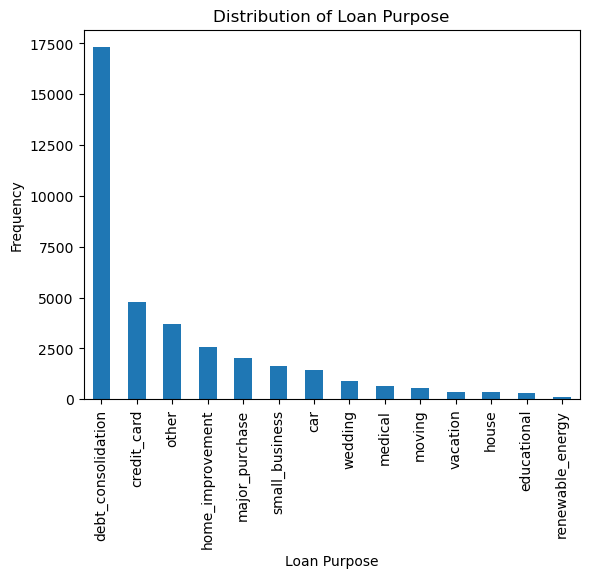

In [147]:
#univariate analysis - check peropose of loan taken
ax = loan_details['purpose'].value_counts().plot.bar()
ax.set_title('Distribution of Loan Purpose')
ax.set_xlabel('Loan Purpose')
ax.set_ylabel('Frequency')
plt.show()

#most of the taken debt consolidation perpose.

In [148]:
#performing segmented univariate analysis by creating segment for loans which are charged off & Fully Paid

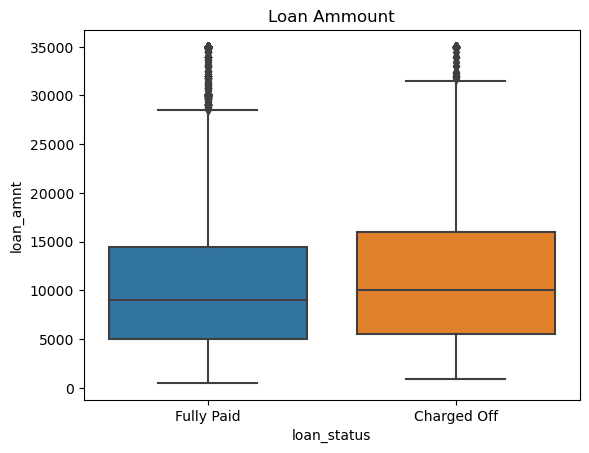

In [149]:
#segmented univariate - loan_amt
ax = sns.boxplot(x=loan_details['loan_status'],y=loan_details['loan_amnt'])
ax.set_title('Loan Ammount')
plt.show()

#majority of Fully paid loans falls under 5000 to 15000 & majority of charged off loans falls under 5000 to 17000.
#by looking at median, the risk of loan to be charged off is higher if loan_amt > 10000

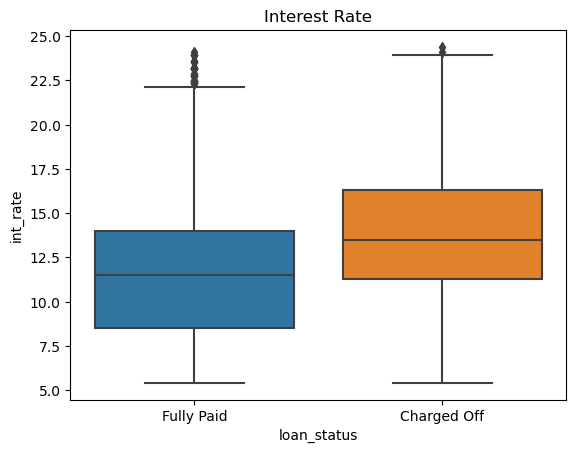

In [150]:
#segmented univariate - int_rate
ax = sns.boxplot(x=loan_details['loan_status'],y=loan_details['int_rate'])
ax.set_title('Interest Rate')
plt.show()

#mejority of interest for fully paid loan is around 8 to 14 & mejority of interest rate for charged off loan is around 11 to 16
#by looking at median, the risk of loan to be charged off will be higher if int_rate > 13

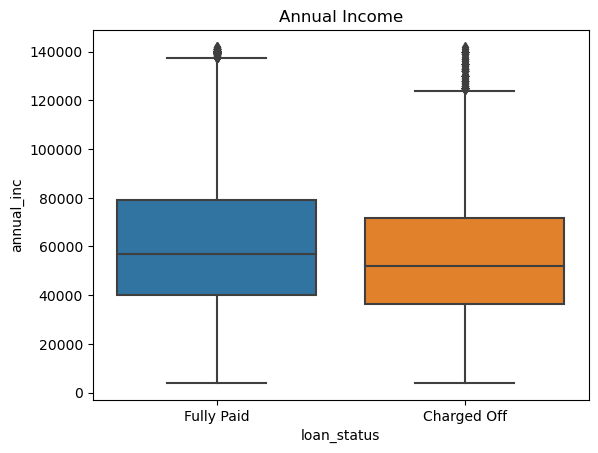

In [151]:
#segmented univariate - annual_inc
ax = sns.boxplot(x=loan_details['loan_status'],y=loan_details['annual_inc'])
ax.set_title('Annual Income')
plt.show()

#mejority of loan applicant who fully paid loan have a income of 40000 to 80000 & most of the loan applicant who charged off
#their loan have a income of 35000 to 70000, by looking at median if risk of charged off loan is more if loan applicant
#income is < 50000

In [152]:
#segmented univariate revolve utilization
loan_details['revol_util']
#sns.boxplot(x=loan_details['loan_status'],y=loan_details['revol_util'])
#plt.show()
#majority of fully paid loan has a revol_util of 25 to 70 & majority of charged off loan have revolve_util of 30 to 75.
#looking at the median the risk of charged off loan will increase if revolve_util is > 50

0        83.7
1         9.4
2        98.5
3        21.0
5        28.3
         ... 
39711    23.0
39712    13.1
39713    26.9
39714    19.4
39716    51.5
Name: revol_util, Length: 36676, dtype: float64

In [153]:
#bivariate analysis.
#create buckets for range of values (split of 20%) which will be used for bivariate analysis

In [154]:
col_lables = ['500-4800','4800-7000','7000-10000','10000-15000','15000-29900']
loan_details['loan_amt_range'] = pd.qcut(loan_details['loan_amnt'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

In [155]:
col_lables = ['5.42-7.88','7.88-10.74','10.74-12.69','12.69-14.84','14.84-22.48']
loan_details['int_rate_range'] = pd.qcut(loan_details['int_rate'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

In [156]:
col_lables = ['15.69-139.24','139.24-214.30','214.30-309.40','309.40-423.09','423.09-799.49']
loan_details['installment_range'] = pd.qcut(loan_details['installment'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

In [157]:
col_lables = ['4000.0-36000.0','36000.0-48000.0','48000.0-60500.0','60500.0-80000.0','80000.0-131040.0']
loan_details['annual_inc_range'] = pd.qcut(loan_details['annual_inc'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

In [158]:
col_lables = ['0.00-7.10','7.10-11.57','11.57-15.50','15.50-19.86','19.86-29.99']
loan_details['dti_range'] = pd.qcut(loan_details['dti'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

In [159]:
col_lables = ['0.0-20.0','20.0-39.8','39.8-58.0','58.0-77.1','77.1-99.9']
loan_details['revol_util_range'] = pd.qcut(loan_details['revol_util'],q=[0,0.2,0.4,0.6,0.8,1],labels=col_lables)

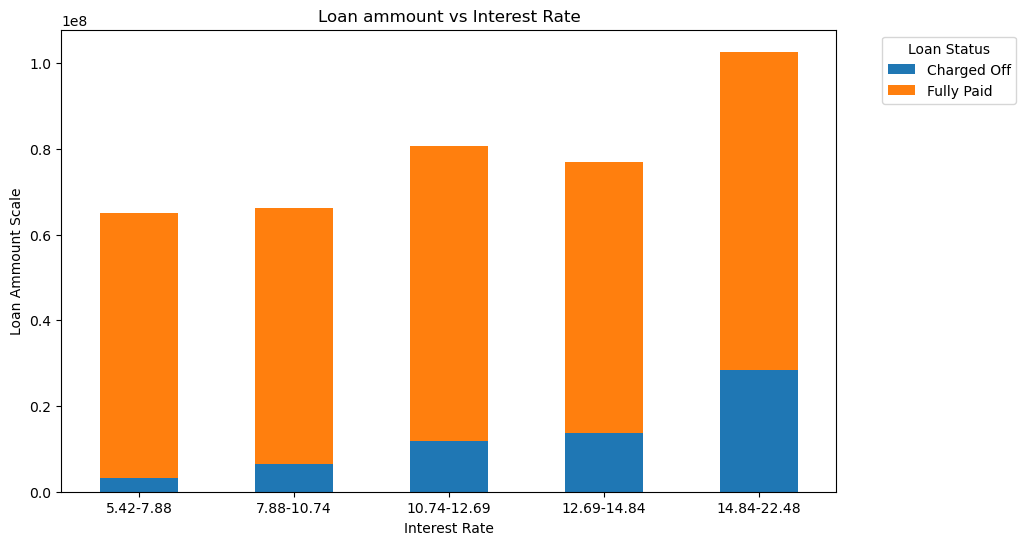

In [160]:
#bivariate analysis on Loan ammount vs Interest Rate
loan_amnt_intrst = pd.pivot_table(data=loan_details,values='loan_amnt',index='int_rate_range',columns='loan_status',aggfunc=sum)
loan_amnt_intrst.plot(kind='bar',stacked='True',figsize=[10,6])
plt.title('Loan ammount vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Loan Ammount Scale')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

#there is more risk of loan to be charged off when there is a higher interest rate for lower ammount of loan

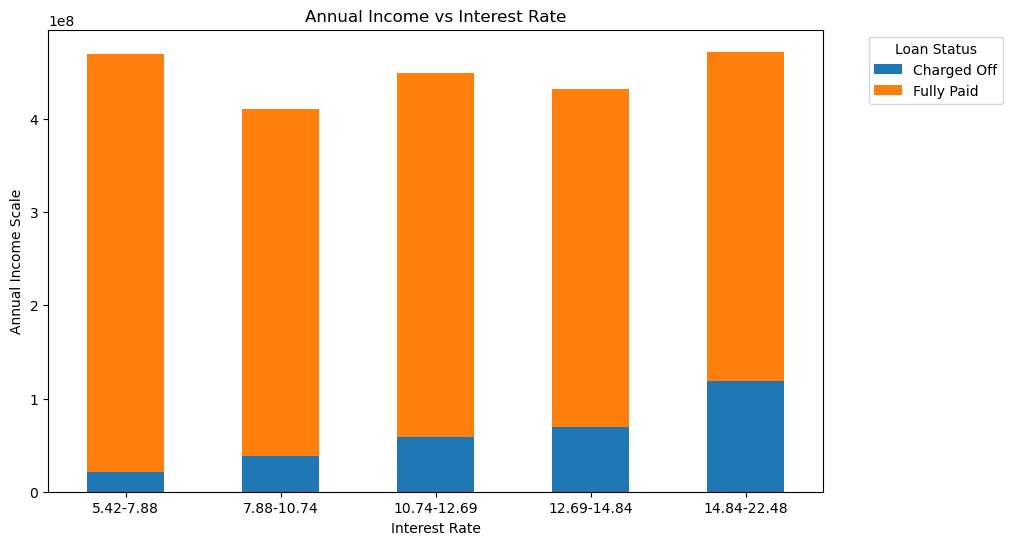

In [161]:
#bivariate analysis on annual income vs interest range
loan_amnt_income = pd.pivot_table(data=loan_details,values='annual_inc',index='int_rate_range',columns='loan_status',aggfunc=sum)
loan_amnt_income.plot(kind='bar',stacked='True',figsize=[10,6])
plt.title('Annual Income vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Annual Income Scale')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

#there is a more risk of loan to be charged off when annual income of applicant is low & interest rate is high

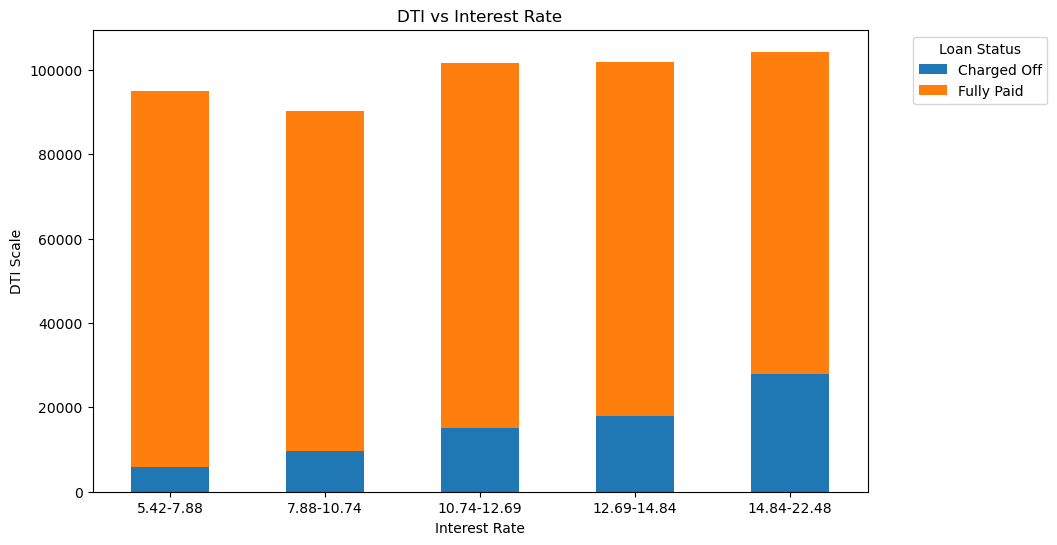

In [162]:
#bivariate analysis on dti vs Interest Rate
loan_amnt_income = pd.pivot_table(data=loan_details,values='dti',index='int_rate_range',columns='loan_status',aggfunc=sum)
loan_amnt_income.plot(kind='bar',stacked='True',figsize=[10,6])
plt.title('DTI vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('DTI Scale')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

#there is a more risk of loan to be charged off when interest rate is high & debt to interest rate is high

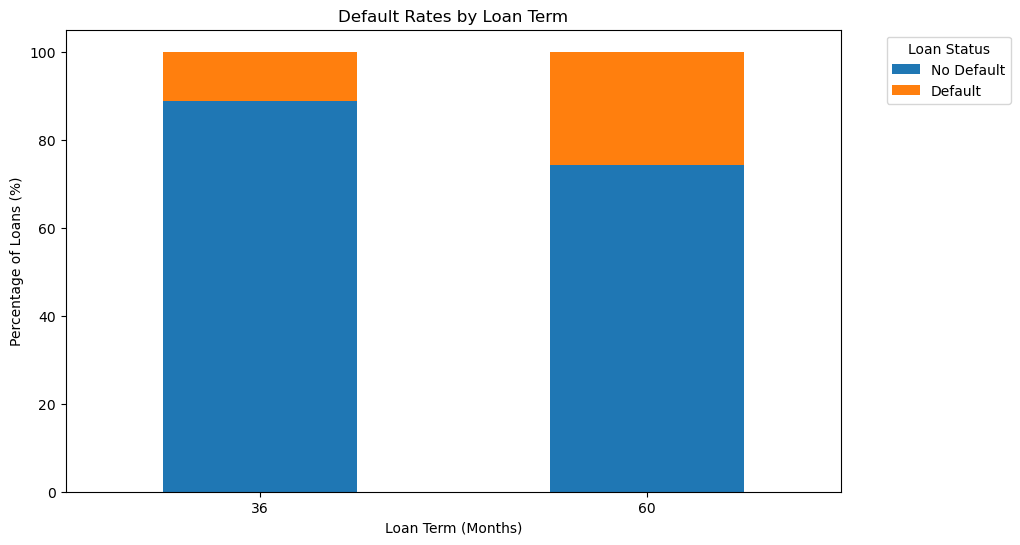

In [163]:
#bivariate analysis on Installment vs Loan ammount

loan_term_default_rate = loan_details.groupby('term')['defaulted'].value_counts(normalize=True).unstack()
loan_term_default_rate = loan_term_default_rate.multiply(100).rename(columns={0: 'No Default', 1: 'Default'})

# Plot the default rates for each loan term category
loan_term_default_rate.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rates by Loan Term')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Percentage of Loans (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

#there is a more risk of loan to be charged off when both loan ammount and tenure is high

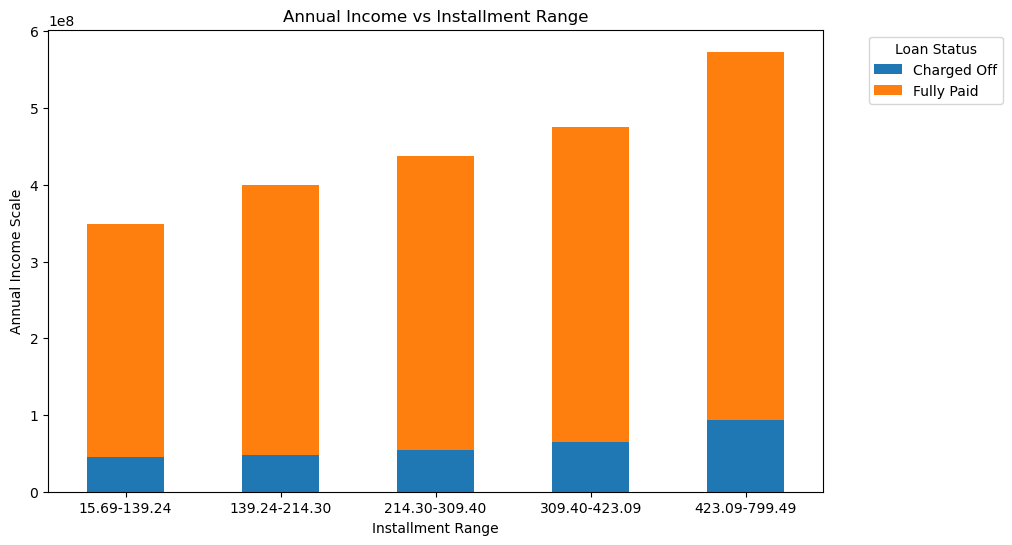

In [164]:
#bivariate analysis on Installment vs annual income
loan_amnt_income = pd.pivot_table(data=loan_details,values='annual_inc',index='installment_range',columns='loan_status',aggfunc=sum)
loan_amnt_income.plot(kind='bar',stacked='True',figsize=[10,6])
plt.title('Annual Income vs Installment Range')
plt.xlabel('Installment Range')
plt.ylabel('Annual Income Scale')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

#there is more chance of loan to be charged off if annual income is less & monthly installment is hiher side.

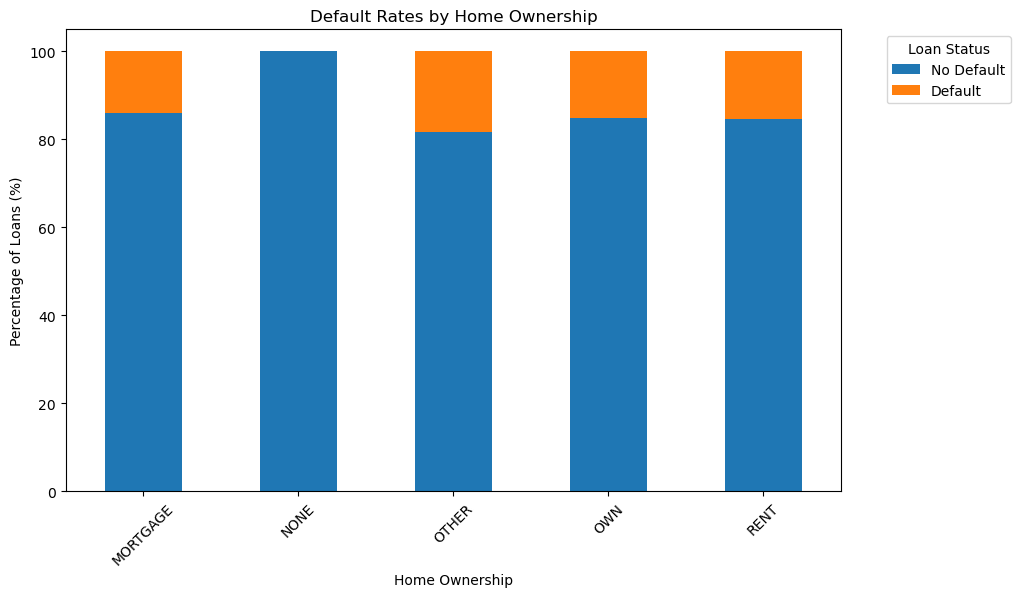

In [165]:
#bivariate analysis - Home Ownership Vs Loan Ammount
home_ownership_default_rate = loan_details.groupby('home_ownership')['defaulted'].value_counts(normalize=True).unstack()
home_ownership_default_rate = home_ownership_default_rate.multiply(100).rename(columns={0: 'No Default', 1: 'Default'})

# Plot the default rates for each category of home ownership
home_ownership_default_rate.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Default Rates by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage of Loans (%)')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

#there is more chance of loan to be charged off if loan ammount is high & applicant does not own a house

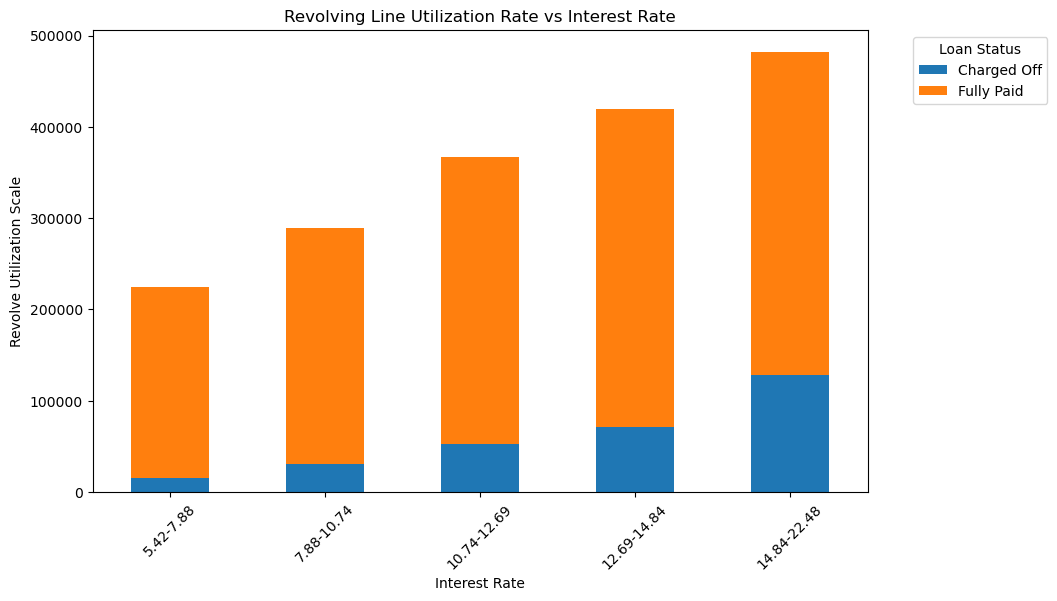

In [166]:
#revolve util vs Interest rate
loan_amnt_income = pd.pivot_table(data=loan_details,values='revol_util',index='int_rate_range',columns='loan_status',aggfunc=sum)
loan_amnt_income.plot(kind='bar',stacked='True',figsize=[10,6])
plt.title('Revolving Line Utilization Rate vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Revolve Utilization Scale')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

#The loan is more likely to be charged off more higher interest rate & higher Revolving Line Utilization Rate.

In [167]:
#observations from Univariate Analysis

#1. most of the loan ammounts are sactioned at lower end of ammount requested i.e around 5000 to 10000
#2. Interest rate is varying howerver most of the loan applications had a interest rate ranging from 7.5 to 15.0.

#3. most of the loan applicant have a employment experience of freshers (0 to 2 Years) or stable income with 10+ years.
#4. dti distribution is below 30%, howerver most loan applicant are having high dti risk ranging from 13 to 20%

#5. most of the loan applicant are having a stable income ranging from 40000 to 80000

#6. most of the loan applicant are living under Rented ot Mortaged property

#7. most of the taken debt consolidation perpose.

#8. majority of Fully paid loans falls under 5000 to 15000 & majority of charged off loans falls under 5000 to 17000.
#by looking at median, the risk of loan to be charged off is higher if loan_amt > 10000

#9 mejority of interest for fully paid loan is around 8 to 14 & mejority of interest rate for charged off loan is around 11 to 16
#by looking at median, the risk of loan to be charged off will be higher if int_rate > 13

#10 mejority of loan applicant who fully paid loan have a income of 40000 to 80000 & most of the loan applicant who charged off
#their loan have a income of 35000 to 70000, by looking at median if risk of charged off loan is more if loan applicant
#income is < 50000

#11. majority of fully paid loan has a revol_util of 25 to 70 & majority of charged off loan have revolve_util of 30 to 75.
#looking at the median the risk of charged off loan will increase if revolve_util is > 50

In [168]:
#observations from Bivariate Analysis

#there is more risk of loan to be charged off when there is a higher interest rate for lower ammount of loan
#there is a more risk of loan to be charged off when annual income of applicant is low & interest rate is high
#there is a more risk of loan to be charged off when interest rate is high & debt to interest rate is high
#there is more chance of loan to be charged off if annual income is less & monthly installment is hiher side.
#there is more chance of loan to be charged off if loan ammount is high & applicant does not own a house
#The loan is more likely to be charged off more higher interest rate & higher Revolving Line Utilization Rate.